# Assessing the skill of WKB solutions to standard baroclinic modes with exponential stratification

In [278]:
from __future__ import division
import numpy as np
from numpy import pi, exp,sqrt,cos
import scipy as sp
import scipy.linalg 
from scipy import integrate
import scipy.optimize as optimize
import scipy.special as special
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 1.

# A simple model for a surface intensified stratification: $N^2(z) = N^2_0 e^{-\alpha z}$

In [282]:
def evals_exact(evals_i,aph,S0):
    """Calculate deformation wavenumbers for exponential N2
        see LaCasce JPO 2012"""
    f = lambda gam: special.j0(2.*gam)*special.y0(2.*gam*exp(-aph/2.)) -\
                    special.y0(2.*gam)*special.j0(2.*gam*exp(-aph/2.))

    gam_est = np.zeros_like(evals_i)

    for i in range(1,evals_i.size):
        gam_est[i] = optimize.newton(f, x0=sqrt(evals_i[i])/(aph*sqrt(S0)), args=(),\
                         tol=1.e-14, maxiter=200)

    evals = aph**2 * S0 * gam_est**2

    return evals

def evecs_exact(evals,zi):
    """Calculate the exact eigenmodes given the wavenumbers
        see LaCasce JPO 2012"""
    phi = lambda gam: exp(aph*zi/2.)*( special.y0(2.*gam)*special.j1(2.*gam*exp(\
                    aph*zi/2.)) -\
                      special.j0(2.*gam)*special.y1(2.*gam*exp(aph*zi/2.)) )

    evecse = np.zeros((zi.size,evals.size))
    for i in range(evals.size):
        if i == 0:
             evecse[:,i] = np.ones_like(zi)
        else:
            gam_est = sqrt(evals/S0)/aph
            evecse[:,i] = phi(gam_est[i])
    
    evecse = normalize(evecse,z)
    
    return evecse

def normalize(evecs,z):
    """ Normalize eigenvector to have unit
            L2 norm """

    ix,iy = evecs.shape
    for i in range(iy):
        int2 = integrate.simps(evecs[:,i]**2,z)
        evecs[:,i] = evecs[:,i]/sqrt(int2)
    return evecs

def evecs_wkb(evals,N,z,f0=1):
     
    h = np.abs(z)[0]
    Nbar = sp.integrate.simps(np.sqrt(N2),x=z)/1.
 
    evecse = np.zeros((z.size,evals.size))
    for i in range(evals.size):
        for j in range(z.size):
            evecse[j,i] = sp.integrate.simps(  (N[:j+1]), z[:j+1] )
        evecse[...,i] = ((-1)**(i))*np.sqrt(2/Nbar)**sqrt(N)*cos((evals[i]/f0)*evecse[...,i])
            
            
    return evecse

In [310]:
def calculate_pmodes(aph=5):
    """This calculates baroclinic modes given the inverse
        e-folding scale of the stratification aph"""
    N02 = 10.
    f2 = 1.
    S0 = f2/N02

    # domain: limits on xi based on z = [-1,0]
    z = np.linspace(-1,0.,500)

    # stratification N2(xi(z))
    N2 = N02*exp(aph*z)
    Nbar = sp.integrate.simps(np.sqrt(N2),x=z)/1.
    nn = 22

    # initial guess, constant strat
    gam_est = ((np.arange(nn)*pi)**2)/((Nbar**2)*1)

    evalse = evals_exact(gam_est,aph,S0)

    #evalswkb = 
    evalswkb = (np.arange(nn)*pi*1/(Nbar*1))**2

    #evals_exact = aph**2 * S0 * gam_est**2
    evalse.sort()
    evecse = evecs_exact(evalse[:],z)

    # wkb
    evecsw = evecs_wkb(np.sqrt(evalswkb),np.sqrt(N2),z,f0=1)
    
    return z, N2, evalse, evecse, evalswkb, evecs_wkb

In [311]:
z, N2, evalse, evecse, evalswkb, evecs_wkb = calculate_pmodes(aph=5)
z, N2_1, evalse_1, evecse_1, evalswkb_1, evecs_wkb_1 = calculate_pmodes(aph=1)



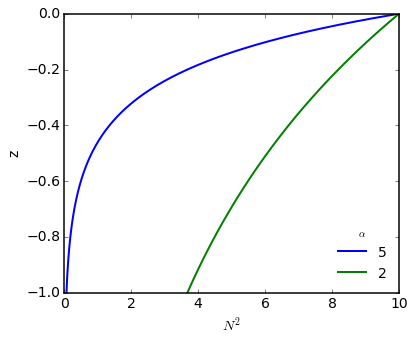

In [312]:
plt.figure(figsize=(6,5))

plt.plot(N2,z,label='5',linewidth=2)
plt.plot(N2_1,z,label='2',linewidth=2)
plt.xlabel(r'$N^2$')
plt.ylabel(r'z')
plt.legend(title=r'$\alpha$',loc=4)
plt.savefig('N2.pdf')

In [313]:
evalswkb

array([    0.        ,     7.32107443,    29.28429773,    65.88966989,
         117.13719092,   183.02686081,   263.55867957,   358.73264719,
         468.54876368,   593.00702904,   732.10744325,   885.85000634,
        1054.23471828,  1237.2615791 ,  1434.93058878,  1647.24174732,
        1874.19505473,  2115.790511  ,  2372.02811614,  2642.90787014,
        2928.42977301,  3228.59382475])

In [314]:
evalse

array([    0.        ,     6.5076748 ,    28.08557214,    64.48088979,
         115.5992893 ,   181.40367667,   261.87627468,   357.00753117,
         466.7919021 ,   591.22598159,   730.30758244,   884.03524871,
        1052.40798177,  1235.42507895,  1433.08603483,  1645.39047876,
        1872.33813423,  2113.92879182,  2370.1622907 ,  2641.03850579,
        2926.55733877,  3226.71871148])

In [315]:
diff_5 = np.abs((evalswkb[1:]-evalse[1:]))/evalse[1:]
diff_1 = np.abs((evalswkb_1[1:]-evalse_1[1:]))/evalse_1[1:]

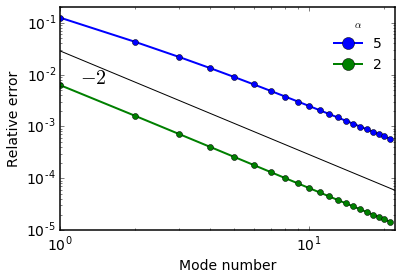

In [324]:
n = np.arange(1,22)
nr = np.array([1.,22])
plt.loglog(n,diff_5,'bo-',linewidth=2,label='5')
plt.loglog(n,diff_1,'go-',linewidth=2,label='2')
plt.legend(title=r'$\alpha$',loc=1)
plt.semilogy(nr,nr**-2/3.5e1,color='k')
plt.ylim(1.e-5,2.e-1)
plt.xlim(0,22.)
plt.text(1.2,.0065,r'$-2$',fontsize=20)
plt.xlabel('Mode number')
plt.ylabel('Relative error')
plt.savefig('RelativeError.pdf')

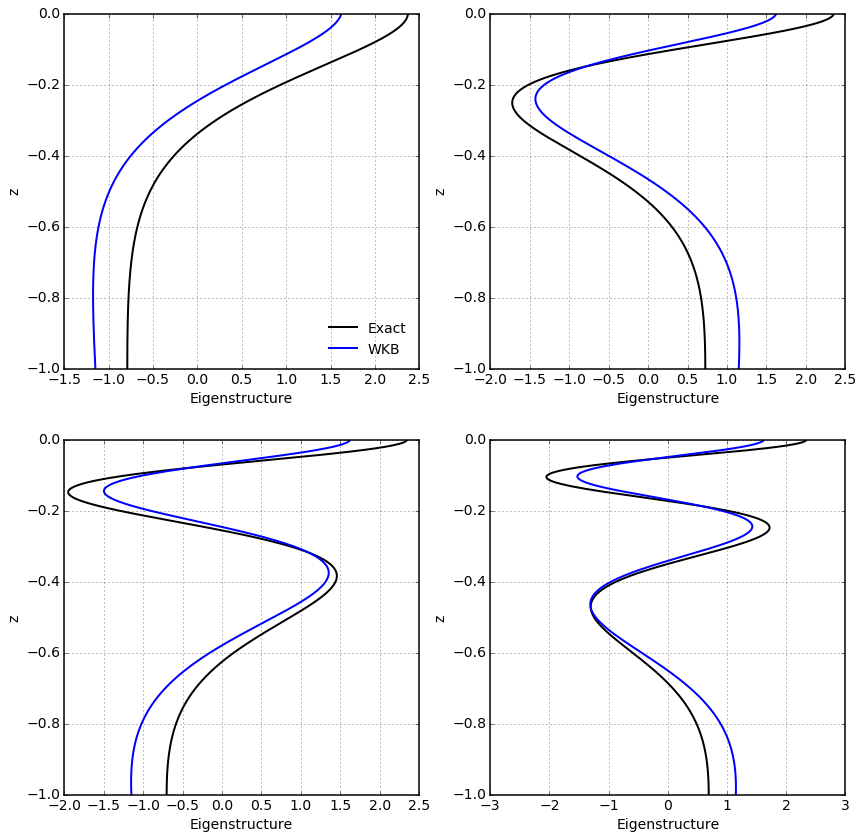

In [306]:
plt.figure(figsize=(14,14))

plt.subplot(221)
plt.plot(evecse[...,1],z,'k',label='Exact',linewidth=2)
plt.plot(evecsw[...,1],z,'b',label='WKB',linewidth=2)

plt.legend(loc=4)

plt.xlabel('Eigenstructure')
plt.ylabel('z')
plt.grid()

plt.subplot(222)
plt.plot(evecse[...,2],z,'k',linewidth=2)
plt.plot(evecsw[...,2],z,linewidth=2)
plt.xlabel('Eigenstructure')
plt.ylabel('z')
plt.grid()

plt.subplot(223)
plt.plot(evecse[...,3],z,'k',linewidth=2)
plt.plot(evecsw[...,3],z,linewidth=2)
plt.xlabel('Eigenstructure')
plt.ylabel('z')
plt.grid()

plt.subplot(224)
plt.plot(evecse[...,4],z,'k',linewidth=2)
plt.plot(evecsw[...,4],z,linewidth=2)
plt.xlabel('Eigenstructure')
plt.ylabel('z')
plt.grid()
plt.savefig('Eigenstructure.pdf')